In [ ]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)
!ls '/content/gdrive/MyDrive/Datasets'

Mounted at /content/gdrive
Dataset_bsl


In [ ]:
!pip install memory-profiler
!pip install mediapipe opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 39.2 MB/s eta 0:00:00


In [ ]:
import os
import pathlib
import glob
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import mediapipe as mp
import uuid
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
class_list=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37']


dataset_path = '/content/gdrive/MyDrive/Datasets/Dataset_bsl/RESIZED_TESTING_DATA'
image_paths = []
labels = []

for i in class_list:
    for folder_name in os.listdir(dataset_path):
        if folder_name == i:
            folder_path = os.path.join(dataset_path, folder_name)
            image_paths.append(folder_path)

for i in image_paths:
    print(i.rsplit('/', 1)[-1], end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 

# Dataset

In [ ]:
x = np.load('/content/gdrive/MyDrive/Datasets/Dataset_bsl/RESIZED_TESTING_DATA/test_o_img.npy')
y = np.load('/content/gdrive/MyDrive/Datasets/Dataset_bsl/RESIZED_TESTING_DATA/test_o_lbl.npy')

In [ ]:
y.shape

(1520,)

In [ ]:
x.shape

(1520, 224, 224, 3)

## MODEL-1 Dataset

In [ ]:
test_img_model1 = []
test_label_model1 = y

for i in range(len(x)):
    image = x[i]
    image = cv2.resize(image, (64,64), interpolation = cv2.INTER_AREA)
    image = image.astype('float32')
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val)
    test_img_model1.append(image)

test_img_model1 = np.array(test_img_model1)
test_label_model1 = np.array(test_label_model1)

test_img_model1.shape

(1520, 64, 64, 3)

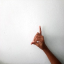

In [ ]:
cv2_imshow(test_img_model1[123]*255)

## MODEL-2 Dataset

In [ ]:
test_img_model2 = []
test_label_model2 = y


for i in range(len(x)):
    frame = x[i]
    frame = cv2.resize(frame, (224, 224))
    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils

    with mp_hands.Hands(min_detection_confidence=0.2, min_tracking_confidence=0.5) as hands:
        # BGR 2 RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert to uint8
        image = image.astype(np.uint8)

        # Set flag
        image.flags.writeable = False

        # Detections
        results = hands.process(image)

        # Set flag to true
        image.flags.writeable = True

        # Create a black background image
        image = np.zeros_like(image)

        # Rendering results
        if results.multi_hand_landmarks:
            for num, hand in enumerate(results.multi_hand_landmarks):
                mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS,
                                        mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                        mp_drawing.DrawingSpec(color=(250, 44, 250), thickness=2, circle_radius=2),
                                        )
        image = cv2.resize(image, (64, 64), interpolation=cv2.INTER_AREA)
        test_img_model2.append(image)

test_img_model2 = np.array(test_img_model2)
test_label_model2 = np.array(test_label_model2)

test_img_model2.shape


(1520, 64, 64, 3)

## MODEL-3

In [ ]:
test_img_model3 = []
test_label_model3 = y

count = 0

for i in range(len(x)):
    image = x[i]
    # backup = image
    frame = image
    frame = cv2.resize(frame, (224, 224))

    # Initialize MediaPipe Hands
    mp_hands = mp.solutions.hands

    # Number of pixels to increase the bounding box size
    padding = 0.15

    with mp_hands.Hands(min_detection_confidence=0, min_tracking_confidence=0.5) as hands:
        # BGR 2 RGB
        frame = frame.astype(np.uint8)
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Set flag
        image.flags.writeable = False

        image = image.astype(np.uint8)
        # Detections
        results = hands.process(image)

        # Set flag to true
        image.flags.writeable = True

        # RGB 2 BGR
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        backup = image
        # Detections
        if results.multi_hand_landmarks:
            for num, hand in enumerate(results.multi_hand_landmarks):
                # Get the bounding box coordinates
                xcord = [landmark.x for landmark in hand.landmark]
                ycord = [landmark.y for landmark in hand.landmark]

                xmin, xmax = min(xcord), max(xcord)
                ymin, ymax = min(ycord), max(ycord)

                # Increase the bounding box size
                xmin -= padding
                xmax += padding
                ymin -= padding
                ymax += padding

                # Convert the bounding box coordinates to pixel values
                xmin_pixel = int(xmin * image.shape[1])
                xmax_pixel = int(xmax * image.shape[1])
                ymin_pixel = int(ymin * image.shape[0])
                ymax_pixel = int(ymax * image.shape[0])

                # Check if resized image has valid data
                if xmin_pixel<0 or xmax_pixel<0 or ymin_pixel<0 or ymax_pixel<0:
                    # Use the original image if the resized image has invalid data
                    image_cropped = backup
                    print('Crop not possible, index:', i)
                    print('label', y[i])

                else:
                    # Crop the region within the bounding box
                    image_cropped = image[ymin_pixel:ymax_pixel, xmin_pixel:xmax_pixel]

                # Resize the cropped image to 224x224
                image_resized = cv2.resize(image_cropped, (224, 224))

                # Perform edge detection
                blur1 = image_resized
                canny1 = cv2.Canny(blur1, threshold1=140, threshold2=80)

                image_processed = cv2.resize(canny1, (64, 64))
                image_processed = cv2.cvtColor(image_processed, cv2.COLOR_GRAY2RGB)
                image_processed = image_processed.astype('float32')
        # else:
        #     image_resized = cv2.resize(backup, (224, 224))

        #     # Perform edge detection
        #     blur1 = image_resized
        #     canny1 = cv2.Canny(blur1, threshold1=140, threshold2=80)

        #     image_processed = cv2.resize(canny1, (64, 64))
        #     image_processed = cv2.cvtColor(image_processed, cv2.COLOR_GRAY2RGB)
        #     image_processed = image_processed.astype('float32')

    test_img_model3.append(image_processed)

test_img_model3 = np.array(test_img_model3)
test_label_model3 = np.array(test_label_model3)

test_img_model3.shape


Crop not possible, index: 6
label 34
Crop not possible, index: 14
label 34
Crop not possible, index: 19
label 34
Crop not possible, index: 32
label 34
Crop not possible, index: 33
label 34
Crop not possible, index: 82
label 37
Crop not possible, index: 88
label 37
Crop not possible, index: 96
label 37
Crop not possible, index: 100
label 37
Crop not possible, index: 106
label 37
Crop not possible, index: 107
label 37
Crop not possible, index: 111
label 37
Crop not possible, index: 115
label 37
Crop not possible, index: 117
label 37
Crop not possible, index: 118
label 37
Crop not possible, index: 118
label 37
Crop not possible, index: 127
label 6
Crop not possible, index: 186
label 35
Crop not possible, index: 283
label 4
Crop not possible, index: 365
label 36
Crop not possible, index: 442
label 30
Crop not possible, index: 447
label 30
Crop not possible, index: 447
label 30
Crop not possible, index: 476
label 30
Crop not possible, index: 567
label 32
Crop not possible, index: 570
label 

(1520, 64, 64, 3)

In [ ]:
x.shape

(1520, 224, 224, 3)

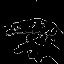

In [ ]:
cv2_imshow(test_img_model3[20])

# load model

In [ ]:
model1 = load_model('/content/gdrive/MyDrive/pre2_models/normalized_dataset_bestfit.h5')
model2 = load_model('/content/gdrive/MyDrive/pre2_models/poseestimatorCNN.h5')
model3 = load_model('/content/gdrive/MyDrive/pre2_models/edgedetectionCNN.h5')

# ENSEMBLE Average Weght

### Test

In [ ]:
# model1_precisions = {

#     0: 0.93,
#     1: 0.97,
#     2: 1.00,
#     3: 0.84,
#     4: 0.73,
#     5: 0.93,
#     6: 1.00,
#     7: 0.95,
#     8: 0.95,
#     9: 0.95,
#     10: 1.00,
#     11: 0.88,
#     12: 1.00,
#     13: 0.90,
#     14: 0.93,
#     15: 0.95,
#     16: 1.00,
#     17: 0.97,
#     18: 0.92,
#     19: 0.91,
#     20: 0.95,
#     21: 0.83,
#     22: 0.62,
#     23: 0.86,
#     24: 0.92,
#     25: 0.97,
#     26: 0.97,
#     27: 0.97,
#     28: 1.00,
#     29: 0.98,
#     30: 0.97,
#     31: 0.95,
#     32: 1.00,
#     33: 0.84,
#     34: 0.98,
#     35: 0.86,
#     36: 0.91,
#     37: 1.00
# }

# model2_precisions = {
#     0: 0.80,
#     1: 0.92,
#     2: 0.91,
#     3: 0.69,
#     4: 0.94,
#     5: 0.90,
#     6: 0.84,
#     7: 0.65,
#     8: 0.69,
#     9: 0.83,
#     10: 0.94,
#     11: 0.82,
#     12: 0.90,
#     13: 0.78,
#     14: 0.67,
#     15: 0.69,
#     16: 0.93,
#     17: 1.00,
#     18: 0.72,
#     19: 0.32,
#     20: 0.89,
#     21: 0.97,
#     22: 0.63,
#     23: 0.92,
#     24: 0.87,
#     25: 0.91,
#     26: 1.00,
#     27: 0.68,
#     28: 0.97,
#     29: 0.95,
#     30: 0.98,
#     31: 1.00,
#     32: 0.97,
#     33: 0.86,
#     34: 0.97,
#     35: 0.79,
#     36: 0.92,
#     37: 0.97

# }

# model3_precisions = {

#     0: 0.79,
#     1: 0.90,
#     2: 0.89,
#     3: 0.66,
#     4: 0.60,
#     5: 0.82,
#     6: 0.81,
#     7: 0.85,
#     8: 0.90,
#     9: 0.80,
#     10: 0.95,
#     11: 0.89,
#     12: 0.81,
#     13: 0.75,
#     14: 0.80,
#     15: 0.88,
#     16: 0.88,
#     17: 0.88,
#     18: 0.76,
#     19: 0.90,
#     20: 0.95,
#     21: 0.90,
#     22: 0.67,
#     23: 0.89,
#     24: 0.91,
#     25: 0.89,
#     26: 0.90,
#     27: 0.95,
#     28: 0.97,
#     29: 0.90,
#     30: 0.97,
#     31: 0.95,
#     32: 0.87,
#     33: 0.84,
#     34: 0.97,
#     35: 0.80,
#     36: 0.92,
#     37: 0.97

# }

## Precision

In [ ]:
model1_precisions = {
    0: 1.00,
    1: 0.98,
    2: 0.99,
    3: 0.93,
    4: 0.99,
    5: 0.98,
    6: 0.98,
    7: 0.97,
    8: 0.98,
    9: 0.98,
    10: 0.99,
    11: 0.99,
    12: 0.99,
    13: 0.99,
    14: 0.98,
    15: 0.99,
    16: 0.99,
    17: 0.99,
    18: 0.95,
    19: 0.98,
    20: 0.98,
    21: 1.00,
    22: 0.94,
    23: 0.95,
    24: 0.97,
    25: 0.98,
    26: 0.98,
    27: 0.96,
    28: 0.99,
    29: 0.99,
    30: 0.97,
    31: 0.98,
    32: 0.95,
    33: 0.96,
    34: 0.99,
    35: 0.96,
    36: 0.98,
    37: 1.00
}
model2_precisions = {
    0: 0.94,
    1: 0.93,
    2: 0.96,
    3: 0.88,
    4: 0.96,
    5: 0.86,
    6: 0.84,
    7: 0.83,
    8: 0.87,
    9: 0.94,
    10: 0.97,
    11: 0.93,
    12: 0.96,
    13: 0.90,
    14: 0.83,
    15: 0.88,
    16: 1.00,
    17: 0.99,
    18: 0.85,
    19: 0.95,
    20: 0.97,
    21: 1.00,
    22: 0.85,
    23: 0.94,
    24: 0.96,
    25: 0.99,
    26: 0.99,
    27: 0.93,
    28: 0.99,
    29: 0.97,
    30: 0.97,
    31: 0.99,
    32: 0.95,
    33: 0.93,
    34: 0.98,
    35: 0.95,
    36: 0.93,
    37: 0.92
}
model3_precisions = {
    0: 0.98,
    1: 0.96,
    2: 0.98,
    3: 0.96,
    4: 0.95,
    5: 0.96,
    6: 0.96,
    7: 0.96,
    8: 0.98,
    9: 0.97,
    10: 0.96,
    11: 0.99,
    12: 0.94,
    13: 0.98,
    14: 0.97,
    15: 0.98,
    16: 0.97,
    17: 0.95,
    18: 0.95,
    19: 0.96,
    20: 0.98,
    21: 0.97,
    22: 0.94,
    23: 0.93,
    24: 0.95,
    25: 0.99,
    26: 0.96,
    27: 1.00,
    28: 0.99,
    29: 0.99,
    30: 0.96,
    31: 0.99,
    32: 0.98,
    33: 0.96,
    34: 0.98,
    35: 0.97,
    36: 0.98,
    37: 0.93
}

## Model Predictions

In [ ]:
from sklearn.metrics import accuracy_score



# Initialize empty arrays to store predictions
predictions_model1 = np.zeros_like(test_label_model1)
predictions_model2 = np.zeros_like(test_label_model1)
predictions_model3 = np.zeros_like(test_label_model1)

# Make predictions using each base model
predictions_model1 = model1.predict(test_img_model1)
predictions_model2 = model2.predict(test_img_model2)
predictions_model3 = model3.predict(test_img_model3)

# Initialize ensemble predictions array
ensemble_predictions = np.zeros((len(test_img_model3), 38))  # Updated initialization


# Iterate over each sample and calculate ensemble predictions
for i in range(len(test_label_model1)):
    # Get the predicted class for each model
    predicted_class_model1 = np.argmax(predictions_model1[i])
    predicted_class_model2 = np.argmax(predictions_model2[i])
    predicted_class_model3 = np.argmax(predictions_model3[i])

    # Retrieve the precision values based on the predicted classes
    precision_model1 = model1_precisions.get(predicted_class_model1)
    precision_model2 = model2_precisions.get(predicted_class_model2)
    precision_model3 = model3_precisions.get(predicted_class_model3)

    # Calculate weights based on precision values
    weight_model1 = precision_model1
    weight_model2 = precision_model2
    weight_model3 = precision_model3

    # Calculate ensemble prediction by weighted averaging
    ensemble_predictions[i] = (weight_model1 * predictions_model1[i] +
                               weight_model2 * predictions_model2[i] +
                               weight_model3 * predictions_model3[i]) / 3.0

# Evaluate ensemble predictions
ensemble_accuracy = accuracy_score(test_label_model1, ensemble_predictions.argmax(axis=1))


# Calculate accuracy for each base model
accuracy_model1 = accuracy_score(test_label_model1, predictions_model1.argmax(axis=1))
accuracy_model2 = accuracy_score(test_label_model1, predictions_model2.argmax(axis=1))
accuracy_model3 = accuracy_score(test_label_model1, predictions_model3.argmax(axis=1))

# Print accuracy of each base model
print("Base Model 1 Accuracy:", accuracy_model1)
print("Base Model 2 Accuracy:", accuracy_model2)
print("Base Model 3 Accuracy:", accuracy_model3)

print("Dynamic Ensemble Accuracy:", ensemble_accuracy)

48/48 [==============================] - 1s 8ms/step
Base Model 1 Accuracy: 0.9243421052631579
Base Model 2 Accuracy: 0.8184210526315789
Base Model 3 Accuracy: 0.8585526315789473
Dynamic Ensemble Accuracy: 0.9480263157894737


In [ ]:
from sklearn.metrics import accuracy_score

# Initialize empty arrays to store predictions
predictions_model1 = np.zeros_like(test_label_model1)
predictions_model2 = np.zeros_like(test_label_model1)
predictions_model3 = np.zeros_like(test_label_model1)

# Make predictions using each base model
predictions_model1 = model1.predict(test_img_model1)
predictions_model2 = model2.predict(test_img_model2)
predictions_model3 = model3.predict(test_img_model3)

# Initialize ensemble predictions array
ensemble_predictions = np.zeros((len(test_img_model3), 38))

# Iterate over each sample and calculate ensemble predictions
for i in range(len(test_label_model1)):
    # Get the predicted class for each model
    predicted_class_model1 = np.argmax(predictions_model1[i])
    predicted_class_model2 = np.argmax(predictions_model2[i])
    predicted_class_model3 = np.argmax(predictions_model3[i])

    # Calculate ensemble prediction by simple averaging
    ensemble_predictions[i] = (predictions_model1[i] +
                               predictions_model2[i] +
                               predictions_model3[i]) / 3.0

# Evaluate ensemble predictions
ensemble_accuracy = accuracy_score(test_label_model1, ensemble_predictions.argmax(axis=1))

# Calculate accuracy for each base model
accuracy_model1 = accuracy_score(test_label_model1, predictions_model1.argmax(axis=1))
accuracy_model2 = accuracy_score(test_label_model1, predictions_model2.argmax(axis=1))
accuracy_model3 = accuracy_score(test_label_model1, predictions_model3.argmax(axis=1))

# Print accuracy of each base model
print("Base Model 1 Accuracy:", accuracy_model1)
print("Base Model 2 Accuracy:", accuracy_model2)
print("Base Model 3 Accuracy:", accuracy_model3)

print("Unweighted Ensemble Accuracy:", ensemble_accuracy)


48/48 [==============================] - 0s 7ms/step
Base Model 1 Accuracy: 0.9243421052631579
Base Model 2 Accuracy: 0.8184210526315789
Base Model 3 Accuracy: 0.8585526315789473
Unweighted Ensemble Accuracy: 0.95


In [ ]:
from sklearn.metrics import accuracy_score

# Initialize empty arrays to store predictions
predictions_model1 = np.zeros_like(test_label_model1)
predictions_model2 = np.zeros_like(test_label_model1)
predictions_model3 = np.zeros_like(test_label_model1)

# Make predictions using each base model
predictions_model1 = model1.predict(test_img_model1)
predictions_model2 = model2.predict(test_img_model2)
predictions_model3 = model3.predict(test_img_model3)

# Initialize ensemble predictions array
ensemble_predictions = np.zeros((len(test_img_model3), 38))

# Define static weights for each model
weight_model1 = 0.98
weight_model2 = 0.93
weight_model3 = 0.97

# Iterate over each sample and calculate ensemble predictions
for i in range(len(test_label_model1)):
    # Get the predicted class for each model
    predicted_class_model1 = np.argmax(predictions_model1[i])
    predicted_class_model2 = np.argmax(predictions_model2[i])
    predicted_class_model3 = np.argmax(predictions_model3[i])

    # Calculate ensemble prediction using static weights
    ensemble_predictions[i] = (weight_model1 * predictions_model1[i] +
                               weight_model2 * predictions_model2[i] +
                               weight_model3 * predictions_model3[i]) / (weight_model1 + weight_model2 + weight_model3)

# Evaluate ensemble predictions
ensemble_accuracy = accuracy_score(test_label_model1, ensemble_predictions.argmax(axis=1))

# Calculate accuracy for each base model
accuracy_model1 = accuracy_score(test_label_model1, predictions_model1.argmax(axis=1))
accuracy_model2 = accuracy_score(test_label_model1, predictions_model2.argmax(axis=1))
accuracy_model3 = accuracy_score(test_label_model1, predictions_model3.argmax(axis=1))

# Print accuracy of each base model
print("Base Model 1 Accuracy:", accuracy_model1)
print("Base Model 2 Accuracy:", accuracy_model2)
print("Base Model 3 Accuracy:", accuracy_model3)

print("Static Weight Ensemble Accuracy:", ensemble_accuracy)


48/48 [==============================] - 0s 8ms/step
Base Model 1 Accuracy: 0.9243421052631579
Base Model 2 Accuracy: 0.8184210526315789
Base Model 3 Accuracy: 0.8585526315789473
Static Weight Ensemble Accuracy: 0.9513157894736842


#advance meta learner

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from keras.models import load_model
from keras.utils import to_categorical

# Convert the labels to one-hot encoded format
num_classes = 38
test_label_model1_one_hot = to_categorical(test_label_model1, num_classes)
test_label_model2_one_hot = to_categorical(test_label_model2, num_classes)
test_label_model3_one_hot = to_categorical(test_label_model3, num_classes)

# Split the data into training and validation sets for each base model
X_train_model1, X_val_model1, y_train_model1, y_val_model1 = train_test_split(test_img_model1, test_label_model1_one_hot, test_size=0.2, random_state=42)
X_train_model2, X_val_model2, y_train_model2, y_val_model2 = train_test_split(test_img_model2, test_label_model2_one_hot, test_size=0.2, random_state=42)
X_train_model3, X_val_model3, y_train_model3, y_val_model3 = train_test_split(test_img_model3, test_label_model3_one_hot, test_size=0.2, random_state=42)

# Make predictions on the validation sets for each base model
val_predictions_model1 = model1.predict(X_val_model1)
val_predictions_model2 = model2.predict(X_val_model2)
val_predictions_model3 = model3.predict(X_val_model3)

# Apply weights to the predictions of each base model
weighted_val_predictions_model1 = val_predictions_model1 * weight_model1
weighted_val_predictions_model2 = val_predictions_model2 * weight_model2
weighted_val_predictions_model3 = val_predictions_model3 * weight_model3

# Create the validation dataset for the meta-learner
meta_val_data = np.column_stack((weighted_val_predictions_model1, weighted_val_predictions_model2, weighted_val_predictions_model3))

# Train the meta-learner model
meta_learner = RandomForestClassifier()
meta_learner.fit(meta_val_data, y_val_model1.argmax(axis=1))  # Convert one-hot encoded labels to categorical labels

# Make predictions using each base model on the test set
test_predictions_model1 = model1.predict(X_train_model1)
test_predictions_model2 = model2.predict(X_train_model2)
test_predictions_model3 = model3.predict(X_train_model3)

# Apply weights to the predictions of each base model
weighted_test_predictions_model1 = test_predictions_model1 * weight_model1
weighted_test_predictions_model2 = test_predictions_model2 * weight_model2
weighted_test_predictions_model3 = test_predictions_model3 * weight_model3

# Create the test dataset for the meta-learner
meta_test_data = np.column_stack((weighted_test_predictions_model1, weighted_test_predictions_model2, weighted_test_predictions_model3))

# Make predictions using the meta-learner
meta_learner_predictions = meta_learner.predict(meta_test_data)

# Calculate accuracy for each base model
accuracy_model1 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model1.argmax(axis=1))
accuracy_model2 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model2.argmax(axis=1))
accuracy_model3 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model3.argmax(axis=1))

# Calculate accuracy of the meta-learner
meta_learner_accuracy = accuracy_score(y_train_model1.argmax(axis=1), meta_learner_predictions)

# Print accuracy of each base model
print("Base Model 1 Accuracy:", accuracy_model1)
print("Base Model 2 Accuracy:", accuracy_model2)
print("Base Model 3 Accuracy:", accuracy_model3)

print("Wegihted RandomForest Meta-Learner Accuracy:", meta_learner_accuracy)


38/38 [==============================] - 0s 10ms/step
Base Model 1 Accuracy: 0.9243421052631579
Base Model 2 Accuracy: 0.8157894736842105
Base Model 3 Accuracy: 0.850328947368421
Wegihted RandomForest Meta-Learner Accuracy: 0.9136513157894737


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from keras.models import load_model
from keras.utils import to_categorical

# Convert the labels to one-hot encoded format
num_classes = 38
test_label_model1_one_hot = to_categorical(test_label_model1, num_classes)
test_label_model2_one_hot = to_categorical(test_label_model2, num_classes)
test_label_model3_one_hot = to_categorical(test_label_model3, num_classes)

# Split the data into training and validation sets for each base model
X_train_model1, X_val_model1, y_train_model1, y_val_model1 = train_test_split(test_img_model1, test_label_model1_one_hot, test_size=0.2, random_state=42)
X_train_model2, X_val_model2, y_train_model2, y_val_model2 = train_test_split(test_img_model2, test_label_model2_one_hot, test_size=0.2, random_state=42)
X_train_model3, X_val_model3, y_train_model3, y_val_model3 = train_test_split(test_img_model3, test_label_model3_one_hot, test_size=0.2, random_state=42)

# Make predictions on the validation sets for each base model
val_predictions_model1 = model1.predict(X_val_model1)
val_predictions_model2 = model2.predict(X_val_model2)
val_predictions_model3 = model3.predict(X_val_model3)

# Apply weights to the predictions of each base model
weighted_val_predictions_model1 = val_predictions_model1 * weight_model1
weighted_val_predictions_model2 = val_predictions_model2 * weight_model2
weighted_val_predictions_model3 = val_predictions_model3 * weight_model3

# Create the validation dataset for the meta-learner
meta_val_data = np.column_stack((weighted_val_predictions_model1, weighted_val_predictions_model2, weighted_val_predictions_model3))

# Train the meta-learner model
meta_learner = SVC()
meta_learner.fit(meta_val_data, y_val_model1.argmax(axis=1))  # Convert one-hot encoded labels to categorical labels

# Make predictions using each base model on the test set
test_predictions_model1 = model1.predict(X_train_model1)
test_predictions_model2 = model2.predict(X_train_model2)
test_predictions_model3 = model3.predict(X_train_model3)

# Apply weights to the predictions of each base model
weighted_test_predictions_model1 = test_predictions_model1 * weight_model1
weighted_test_predictions_model2 = test_predictions_model2 * weight_model2
weighted_test_predictions_model3 = test_predictions_model3 * weight_model3

# Create the test dataset for the meta-learner
meta_test_data = np.column_stack((weighted_test_predictions_model1, weighted_test_predictions_model2, weighted_test_predictions_model3))

# Make predictions using the meta-learner
meta_learner_predictions = meta_learner.predict(meta_test_data)

# Calculate accuracy for each base model
accuracy_model1 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model1.argmax(axis=1))
accuracy_model2 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model2.argmax(axis=1))
accuracy_model3 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model3.argmax(axis=1))

# Calculate accuracy of the meta-learner
meta_learner_accuracy = accuracy_score(y_train_model1.argmax(axis=1), meta_learner_predictions)

# Print accuracy of each base model
print("Base Model 1 Accuracy:", accuracy_model1)
print("Base Model 2 Accuracy:", accuracy_model2)
print("Base Model 3 Accuracy:", accuracy_model3)

print("Weighted SVM Meta-Learner Accuracy:", meta_learner_accuracy)


38/38 [==============================] - 1s 13ms/step
Base Model 1 Accuracy: 0.9243421052631579
Base Model 2 Accuracy: 0.8157894736842105
Base Model 3 Accuracy: 0.850328947368421
Weighted SVM Meta-Learner Accuracy: 0.9194078947368421


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from keras.models import load_model
from keras.utils import to_categorical

# Convert the labels to one-hot encoded format
num_classes = 38
test_label_model1_one_hot = to_categorical(test_label_model1, num_classes)
test_label_model2_one_hot = to_categorical(test_label_model2, num_classes)
test_label_model3_one_hot = to_categorical(test_label_model3, num_classes)

# Split the data into training and validation sets for each base model
X_train_model1, X_val_model1, y_train_model1, y_val_model1 = train_test_split(test_img_model1, test_label_model1_one_hot, test_size=0.2, random_state=42)
X_train_model2, X_val_model2, y_train_model2, y_val_model2 = train_test_split(test_img_model2, test_label_model2_one_hot, test_size=0.2, random_state=42)
X_train_model3, X_val_model3, y_train_model3, y_val_model3 = train_test_split(test_img_model3, test_label_model3_one_hot, test_size=0.2, random_state=42)

# Make predictions on the validation sets for each base model
val_predictions_model1 = model1.predict(X_val_model1)
val_predictions_model2 = model2.predict(X_val_model2)
val_predictions_model3 = model3.predict(X_val_model3)

# Apply weights to the predictions of each base model
weighted_val_predictions_model1 = val_predictions_model1 * weight_model1
weighted_val_predictions_model2 = val_predictions_model2 * weight_model2
weighted_val_predictions_model3 = val_predictions_model3 * weight_model3

# Create the validation dataset for the meta-learner
meta_val_data = np.column_stack((weighted_val_predictions_model1, weighted_val_predictions_model2, weighted_val_predictions_model3))

# Train the meta-learner model
meta_learner = KNeighborsClassifier()
meta_learner.fit(meta_val_data, y_val_model1.argmax(axis=1))  # Convert one-hot encoded labels to categorical labels

# Make predictions using each base model on the test set
test_predictions_model1 = model1.predict(X_train_model1)
test_predictions_model2 = model2.predict(X_train_model2)
test_predictions_model3 = model3.predict(X_train_model3)

# Apply weights to the predictions of each base model
weighted_test_predictions_model1 = test_predictions_model1 * weight_model1
weighted_test_predictions_model2 = test_predictions_model2 * weight_model2
weighted_test_predictions_model3 = test_predictions_model3 * weight_model3

# Create the test dataset for the meta-learner
meta_test_data = np.column_stack((weighted_test_predictions_model1, weighted_test_predictions_model2, weighted_test_predictions_model3))

# Make predictions using the meta-learner
meta_learner_predictions = meta_learner.predict(meta_test_data)

# Calculate accuracy for each base model
accuracy_model1 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model1.argmax(axis=1))
accuracy_model2 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model2.argmax(axis=1))
accuracy_model3 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model3.argmax(axis=1))

# Calculate accuracy of the meta-learner
meta_learner_accuracy = accuracy_score(y_train_model1.argmax(axis=1), meta_learner_predictions)

# Print accuracy of each base model
print("Base Model 1 Accuracy:", accuracy_model1)
print("Base Model 2 Accuracy:", accuracy_model2)
print("Base Model 3 Accuracy:", accuracy_model3)

print("Weighted KNN Meta-Learner Accuracy:", meta_learner_accuracy)


38/38 [==============================] - 0s 12ms/step
Base Model 1 Accuracy: 0.9243421052631579
Base Model 2 Accuracy: 0.8157894736842105
Base Model 3 Accuracy: 0.850328947368421
Weighted KNN Meta-Learner Accuracy: 0.9235197368421053


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from keras.utils import to_categorical

# Convert the labels to one-hot encoded format
num_classes = 38
test_label_model1_one_hot = to_categorical(test_label_model1, num_classes)
test_label_model2_one_hot = to_categorical(test_label_model2, num_classes)
test_label_model3_one_hot = to_categorical(test_label_model3, num_classes)

# Split the data into training and validation sets for each base model
X_train_model1, X_val_model1, y_train_model1, y_val_model1 = train_test_split(test_img_model1, test_label_model1_one_hot, test_size=0.2, random_state=42)
X_train_model2, X_val_model2, y_train_model2, y_val_model2 = train_test_split(test_img_model2, test_label_model2_one_hot, test_size=0.2, random_state=42)
X_train_model3, X_val_model3, y_train_model3, y_val_model3 = train_test_split(test_img_model3, test_label_model3_one_hot, test_size=0.2, random_state=42)

# Make predictions on the validation sets for each base model
val_predictions_model1 = model1.predict(X_val_model1)
val_predictions_model2 = model2.predict(X_val_model2)
val_predictions_model3 = model3.predict(X_val_model3)

# Apply weights to the predictions of each base model
weighted_val_predictions_model1 = val_predictions_model1 * weight_model1
weighted_val_predictions_model2 = val_predictions_model2 * weight_model2
weighted_val_predictions_model3 = val_predictions_model3 * weight_model3

# Create the validation dataset for the meta-learner
meta_val_data = np.column_stack((weighted_val_predictions_model1, weighted_val_predictions_model2, weighted_val_predictions_model3))

# Train the meta-learner model (Logistic Regression with one-vs-rest)
meta_learner = LogisticRegression(multi_class='ovr')
meta_learner.fit(meta_val_data, y_val_model1.argmax(axis=1))  # Convert one-hot encoded labels to categorical labels

# Make predictions using each base model on the test set
test_predictions_model1 = model1.predict(X_train_model1)
test_predictions_model2 = model2.predict(X_train_model2)
test_predictions_model3 = model3.predict(X_train_model3)

# Apply weights to the predictions of each base model
weighted_test_predictions_model1 = test_predictions_model1 * weight_model1
weighted_test_predictions_model2 = test_predictions_model2 * weight_model2
weighted_test_predictions_model3 = test_predictions_model3 * weight_model3

# Create the test dataset for the meta-learner
meta_test_data = np.column_stack((weighted_test_predictions_model1, weighted_test_predictions_model2, weighted_test_predictions_model3))

# Make predictions using the meta-learner
meta_learner_predictions = meta_learner.predict(meta_test_data)

# Calculate accuracy for each base model
accuracy_model1 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model1.argmax(axis=1))
accuracy_model2 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model2.argmax(axis=1))
accuracy_model3 = accuracy_score(y_train_model1.argmax(axis=1), test_predictions_model3.argmax(axis=1))

# Calculate accuracy of the meta-learner
meta_learner_accuracy = accuracy_score(y_train_model1.argmax(axis=1), meta_learner_predictions)

# Print accuracy of each base model
print("Base Model 1 Accuracy:", accuracy_model1)
print("Base Model 2 Accuracy:", accuracy_model2)
print("Base Model 3 Accuracy:", accuracy_model3)

print("Weighted Logistic Regression Meta-Learner Accuracy:", meta_learner_accuracy)


38/38 [==============================] - 0s 8ms/step
Base Model 1 Accuracy: 0.9243421052631579
Base Model 2 Accuracy: 0.8157894736842105
Base Model 3 Accuracy: 0.850328947368421
Weighted Logistic Regression Meta-Learner Accuracy: 0.9366776315789473


In [ ]:
#Accuracy: 0.9473684210526315